# Four box model for FHxSA biotransformation in the experimental microcosms

"Nitrifying microorganisms linked to biotransformation of perfluoroalkyl sulfonamido precursors from legacy aqueous film forming foam." **Ruyle et al.**, in review

Code was developed and written by Bridger J Ruyle at Harvard University Biogeochemistry of Global Contaminants Research Group

In [18]:
#Import packages
import matplotlib.pyplot as plt
from seaborn import color_palette
import numpy as np
from scipy.optimize import  minimize
import boxey as bx
from boxey import Process, Input, Model
plt.rcParams.update({'font.size': 16})
color = color_palette('colorblind')

#### Parameters from manuscript (Table 1)

In [2]:
#19°C microcosms
k_control_19 = -0.11 #1/days
C_inf_19 = 0.55 #unitless (normalized concentration)
k_bio_19 = 0.2 #1/days
k_PFHxS_19 = 3.E-2 #nM/days

#29°C microcosms
k_control_29 = -0.28 #1/days
C_inf_29 = 0.72 #unitless (normalized concentration)
k_bio_29 = 0.69 #1/days
k_PFHxS_29 = 8.E-2 #nM/days

#input mass
C_in = 79.96 #nM
V_microcosm = 0.03 #L
M_in = C_in*V_microcosm #nmol

#### Convert k<sub>control</sub> into forward k<sub>1</sub> and backwards k<sub>2</sub> rate constants

Sorption between the aqueous phase and the solids/glassware was modeled using a reversable reaction to a constant concentration:

$$ \frac{dC}{dt} = (C_0 - C_{\infty})e^{k_{control}t}+C_{\infty}$$

Conversion of k<sub>control</sub> into forward k<sub>1</sub> (aqueous --> sorbed) and backwards k<sub>2</sub> (sorbed --> aqueous) rate constants is necessary to parametrize the first order rate box model:

In [3]:
#Sorption reaction in the form of k_control 
def reversible_rxn(t, k, C_0, C_inf):
    return((C_0-C_inf)*np.exp(k*t)+C_inf)

#Sorption reaction in the form of k_1 and k_2
def reversible_rxn_2comp_discrete(t, k1, k2, C1_i, C2_i):
    delta_t = np.diff(t)
    C1 = np.zeros_like(t)
    C2 = np.zeros_like(t)
    
    C1[0] = C1_i
    C2[0] = C2_i
    
    for idx, dt in enumerate(delta_t):
        C1[idx+1] = C1[idx] + dt * (C2[idx]*k2 - C1[idx]*k1)
        C2[idx+1] = C2[idx] + dt * (C1[idx]*k1 - C2[idx]*k2)

    return(C1, C2)

#Wrapper fuction for scipy minimize 
def find_reversible_rxn_2_comp(k1, args):
    k_control = args[0]
    C_inf = args[1]
    theoretical = reversible_rxn(t_fit, k_control, 1, C_inf)
    discrete = reversible_rxn_2comp_discrete(t_fit, k1, (1/(1-C_inf)-1)*k1, 1, 0)
    diff = np.linalg.norm(theoretical - discrete[0])
    return(diff)

In [4]:
#Minimize the difference between two representations of the reactions
t_fit = np.linspace(0, 100, 10001)
sol_19 = minimize(fun = find_reversible_rxn_2_comp, x0 = 0.04, args = [k_control_19, C_inf_19], tol = 1E-3)
sol_29 = minimize(fun = find_reversible_rxn_2_comp, x0 = 0.1, args = [k_control_29, C_inf_29], tol = 1E-3)

In [5]:
#calculate k1 and k2
k1_19 = sol_19.x[0]
k2_19 = (1/(1-C_inf_19)-1)*k1_19
C1_19, C2_19 = reversible_rxn_2comp_discrete(t_fit, k1_19, k2_19, 1, 0)

k1_29 = sol_29.x[0]
k2_29 = (1/(1-C_inf_29)-1)*k1_29
C1_29, C2_29 = reversible_rxn_2comp_discrete(t_fit, k1_29, k2_29, 1, 0)

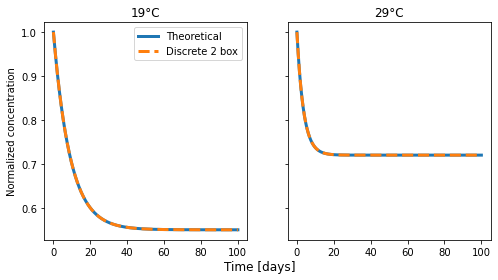

In [6]:
#Plot results to confirm k1 and k2 solution match reversible_rxn solution
fig, ax = plt.subplots(1, 2, figsize = (8, 4), sharex = True, sharey = True)

ax[0].plot(t_fit, reversible_rxn(t_fit, k_control_19, 1, C_inf_19), linewidth = 3, label = 'Theoretical')
ax[0].plot(t_fit, C1_19, linestyle = '--', linewidth = 3, label = 'Discrete 2 box')
ax[0].legend()

ax[1].plot(t_fit, reversible_rxn(t_fit, k_control_29, 1, C_inf_29), linewidth = 3, label = 'Theoretical')
ax[1].plot(t_fit, C1_29, linestyle = '--', linewidth = 3, label = 'Discrete 2 box')

ax[0].set_ylabel('Normalized concentration')
fig.supxlabel('Time [days]')
ax[0].set_title('19°C')
ax[1].set_title('29°C');

#### Box modeling
For a conceptual diagram of the box model, please see the PDF in the folder entitled 'conceptual_model.pdf'

In [13]:
#instatiate models at 19°C and 29°C
compartments = ['aqueous', 'sorbed', 'bio'] #set-up compartments where mass in transfered using first order rates

processes_19 = [
    Process('aq2sorbed', 1/k1_19, 'aqueous', 'sorbed'),
    Process('sorbed2aq', 1/k2_19, 'sorbed', 'aqueous'),
    Process('aq2bio', 1/k_bio_19, 'aqueous', 'bio'),
    Process('bio2aq', 1/k_bio_19, 'bio', 'aqueous'),
    Process('bio_loss', 1/1E-10, 'bio', None)
]
inputs_19 = [Input('PFHxS_generation', -k_PFHxS_19*V_microcosm, None, 'bio')] #add 0th order loss to represent PFHxS production
model_19 = bx.create_model(compartments, processes_19)
model_19 = bx.add_inputs(model_19, inputs_19)

processes_29 = [
    Process('aq2sorbed', 1/k1_29, 'aqueous', 'sorbed'),
    Process('sorbed2aq', 1/k2_29, 'sorbed', 'aqueous'),
    Process('aq2bio', 1/k_bio_29, 'aqueous', 'bio'),
    Process('bio2aq', 1/k_bio_29, 'bio', 'aqueous'),
    Process('bio_loss', 1/1E-10, 'bio', None)
]
inputs_29 = [Input('PFHxS_generation', -k_PFHxS_29*V_microcosm, None, 'bio')] #add 0th order loss to represent PFHxS production
model_29 = bx.create_model(compartments, processes_29)
model_29 = bx.add_inputs(model_29, inputs_29)

In [14]:
#Run models
sol_19, t = model_19.run(np.linspace(0, 10000, 10001), initial_conditions = [M_in, 0, 0])
PFHxS_19 = M_in - np.sum(sol_19, axis = 1)

sol_29, t = model_29.run(np.linspace(0, 10000, 10001), initial_conditions = [M_in, 0, 0])
PFHxS_29 = M_in - np.sum(sol_29, axis = 1)

Text(0.5, 0.01, 'Time [days]')

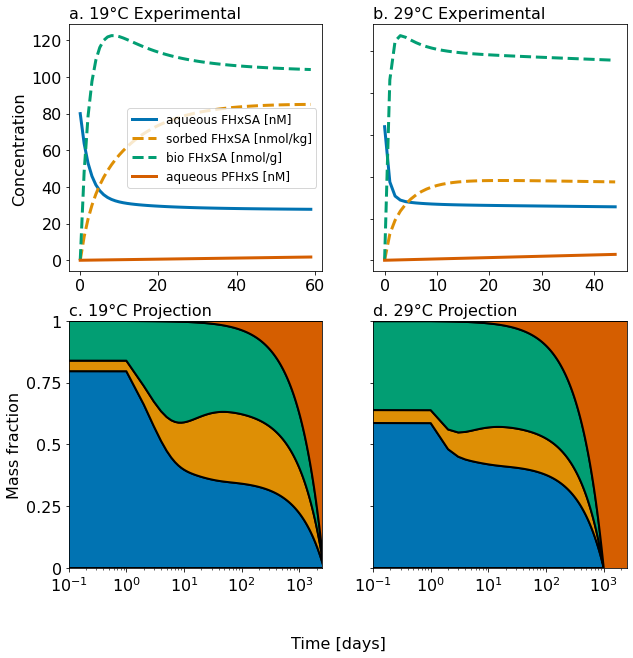

In [29]:
#Plot results
fig, ax = plt.subplots(2, 2, figsize = (10, 10))

#19°C Experimental
ax[0, 0].plot(t[:60], sol_19[:60, 0]/V_microcosm, label = 'aqueous FHxSA [nM]', color = color[0], linewidth = 3)
ax[0, 0].plot(t[:60], 1000*sol_19[:60, 1]/8, label = 'sorbed FHxSA [nmol/kg]', color = color[1], linewidth = 3, linestyle = '--')
ax[0, 0].plot(t[:60], sol_19[:60, 2]/(8*0.001), label = 'bio FHxSA [nmol/g]', color = color[2], linewidth = 3, linestyle = '--')
ax[0, 0].plot(t[:60], PFHxS_19[:60]/V_microcosm, label = 'aqueous PFHxS [nM]', color = color[3], linewidth = 3)
ax[0, 0].set_title('a. 19°C Experimental', loc = 'left', size = 16)
ax[0,0].set_ylabel('Concentration', size = 16)
ax[0, 0].legend(fontsize = 12)

#19°C Projection
ax[1,0].semilogx()
ax[1,0].fill_between(t, 0 , sol_19[:, 0], linewidth = 2, color = color[0], edgecolor = 'k', )
ax[1,0].fill_between(t, sol_19[:, 0] , sol_19[:, 0]+sol_19[:, 1], linewidth = 2, color = color[1], edgecolor = 'k', )
ax[1,0].fill_between(t, sol_19[:, 0]+sol_19[:, 1] , sol_19[:, 0]+sol_19[:, 1]+sol_19[:, 2], linewidth = 2, color = color[2], edgecolor = 'k', )
ax[1,0].fill_between(t, sol_19[:, 0]+sol_19[:, 1]+sol_19[:, 2] , sol_19[:, 0]+sol_19[:, 1]+sol_19[:, 2]+PFHxS_19, linewidth = 2, color = color[3], edgecolor = 'k', )
ax[1,0].set_ylim(0,M_in)
ax[1,0].set_xlim(10**-1, 2500)
ax[1,0].set_yticks(np.linspace(0, M_in, 5))
ax[1,0].set_yticklabels([0, 0.25, 0.5, 0.75, 1])
ax[1,0].set_ylabel('Mass fraction', fontsize = 16)
ax[1,0].set_title('c. 19°C Projection', loc = 'left', size = 16)

#29°C Experimental
ax[0, 1].plot(t[:45], sol_29[:45, 0]/V_microcosm, color = color[0], linewidth = 3)
ax[0, 1].plot(t[:45], 1000*sol_29[:45, 1]/8, color = color[1], linewidth = 3, linestyle = '--')
ax[0, 1].plot(t[:45], sol_29[:45, 2]/(8*0.001), color = color[2], linewidth = 3, linestyle = '--')
ax[0, 1].plot(t[:45], PFHxS_29[:45]/V_microcosm,  color = color[3], linewidth = 3)
ax[0, 1].set_title('b. 29°C Experimental', loc = 'left', size = 16)

#29°C Projection
ax[1,1].semilogx()
ax[1,1].fill_between(t, 0 , sol_29[:, 0], linewidth = 2, color = color[0], edgecolor = 'k', )
ax[1,1].fill_between(t, sol_29[:, 0] , sol_29[:, 0]+sol_29[:, 1], linewidth = 2, color = color[1], edgecolor = 'k', )
ax[1,1].fill_between(t, sol_29[:, 0]+sol_29[:, 1] , sol_29[:, 0]+sol_29[:, 1]+sol_29[:, 2], linewidth = 2, color = color[2], edgecolor = 'k', )
ax[1,1].fill_between(t, sol_29[:, 0]+sol_29[:, 1]+sol_29[:, 2] , sol_29[:, 0]+sol_29[:, 1]+sol_29[:, 2]+PFHxS_29, linewidth = 2, color = color[3], edgecolor = 'k')
ax[1,1].set_ylim(0,M_in)
ax[1,1].set_xlim(10**-1, 2500)
ax[1,1].set_yticks(np.linspace(0, M_in, 5))
ax[1,1].set_yticklabels([0, 0.25, 0.5, 0.75, 1])
ax[1,1].set_title('d. 29°C Projection', loc = 'left', size = 16);


ax[0, 1].set_yticklabels([])
ax[1, 1].set_yticklabels([]);

fig.supxlabel('Time [days]', size = 16, )